In [102]:
# much of this code, particularly the encoder decoder code, is taken from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# the rest is adapted for this project but is still pretty similar

from io import open
import unicodedata
import string
import re
import random
import os

import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

In [22]:
# for start and end of string
SOS_token = 0
EOS_token = 1

# Alphabet class (works with both pinyin and English)
class Alphabet:
    def __init__(self, name):
        self.name = name
        self.letter2index = {}
        self.letter2count = {}
        self.index2letter = {0: "SOS", 1: "EOS"}
        self.n_letters = 2
        
    def add_name(self, name):
        """
        Adds the characters of a name to the alphabet by iterating over them
        and updating the appropriate counts
        """
        for letter in name: # for pinyin we can keep the space as a letter and see if this thing learns syllable boundries
            if letter not in self.letter2index:
                self.letter2index[letter] = self.n_letters
                self.letter2count[letter] = 1
                self.index2letter[self.n_letters] = letter
                self.n_letters += 1
            else:
                self.letter2count[letter] += 1


In [49]:
data_file = os.path.join("..", "data", "EnglishChineseNames_uniq.txt")

def normalize(s):
    """
    Right now just converts a string to lowercase but could be something more later
    (such as removing spaces)
    """
    s = re.sub(r"([-.·])", r"", s) # remove punctuation that seems to have seeped in (including chinese dash)
    return s.lower()

def read_alphabets():
    """
    Creates two alphabets, one for English / Romanized names and the other for pinyin
    Iterates through data file to initialize those alphabets
    """
    input_alph = Alphabet("English")
    output_alph = Alphabet("Pinyin")
    pairs = []
    
    df = pd.read_csv(data_file)
    for row_i, row in df.iterrows():
        english, _, _, pinyin = row
        english = normalize(english)
        pinyin = normalize(pinyin)
        input_alph.add_name(english)
        output_alph.add_name(pinyin) # includes spaces
        pairs.append([english, pinyin])
     
    print("Input names have: {} characters".format(input_alph.n_letters))
    print("Output names have: {} characters".format(output_alph.n_letters))


    return input_alph, output_alph, pairs
        
eng_alph, pin_alph, pairs = read_alphabets()

Input names have: 28 characters
Output names have: 49 characters


In [61]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding is really just a lookup table that takes an index input and returns some k-dimensional vector
        # input_size is size of table, hidden size is number of weights associated with each vector. We really only
        # need this to be a one-hot vector for our purposes so we can probably don't need to explicity represent an 
        # embedding. The smaller our embedding dimension the more information we're giving up
        self.embedding = nn.Embedding(input_size, hidden_size) 
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)#, device=device)

In [62]:
class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # still need an embedding
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) # assume because we have 1-d data
        
    def forward(self, x, hidden):
        output = self.embedding(x).view(1, 1, -1)
        output = F.relu(output) # regularization thing
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0])) # output is only going to have a single thing, so this is legal i guess
        return output, hidden
     

In [63]:
def indexesFromName(alphabet, name):
    return [alphabet.letter2index[l] for l in name]

def tensorFromName(alphabet, name):
    indexes = indexesFromName(alphabet, name)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromName(eng_alph, pair[0])
    target_tensor = tensorFromName(pin_alph, pair[1])
    return (input_tensor, target_tensor)


In [54]:
# how often we use the target input as input to our decoder rather than our decoder's guess
# while training 
teacher_forcing_ratio = 0.5 
MAX_LENGTH = 20


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer,
         criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden() # just 0's
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)
    
    loss = 0 # mission accomplished ;)
    
    # actually run the thing that encodes
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    
    # now its decoder time - this part changes somewhat if you add attention
    decoder_input = torch.tensor([[SOS_token]])
    decoder_hidden = encoder_hidden # no need for an init function
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # target is next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] # bc we're using teacher focing
            
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1) # returns a tuple of the largest value and its index as tensors
            decoder_input = topi.squeeze().detach() # I'm not totally sure what this does
            loss += criterion(decoder_output, target_tensor[di])
            
            if decoder_input.item() == EOS_token:
                break # we're done with this sentence - we don't have to do this above bc it goes to the end of the string automatically
    
    
    # backprop
    loss.backward()
    
    # run SGD which is in the encoder/decoder_optimizer object
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/target_length # not sure what this is, but we can see I guess


In [55]:
# copied directly for profiling...
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [119]:
# Actually do the training:

def trainIters(encoder, decoder, training_pairs, n_iters, print_every=1000, plot_every=100, learning_rate = 0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(training_pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss() # this is... negative log likelihood loss
                             # it's the same as cross-entropy loss bc of the log softmax in the last layer
    
    for iter_i in range(1, n_iters + 1):
        training_pair = training_pairs[iter_i -1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter_i % print_every == 0:
            print_loss_avg = print_loss_total / print_every # calc avg loss
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter_i / n_iters),
                                         iter_i, iter_i / n_iters * 100, print_loss_avg))
        # for plotting loss
        if iter_i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [57]:
%matplotlib inline

#shamelessly copied from tutorial... yikes
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [72]:
# Same as training, just no targets - just rum the thing through the network

def evaluate(encoder, decoder, name, max_len=MAX_LENGTH):
    with torch.no_grad(): # not totally sure what this does tbh - probably stops from updating gradients like we do in training because we are done with training
        input_tensor = tensorFromName(eng_alph, name)
        input_length = input_tensor.size(0) # just the size of the first dimension
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_len, encoder.hidden_size)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0] # is a vector 
        
        # decoder - would have to change if added attention
        decoder_input = torch.tensor([[SOS_token]])
        decoder_hidden = encoder_hidden
        decoded_name = []
        
        for di in range(max_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            
            # transliterate to actual words 
            if topi.item() == EOS_token:
                decoded_name.append("<EOS>")
                break
            else:
                decoded_name.append(pin_alph.index2letter[topi.item()])
            
            decoder_input = topi.squeeze().detach()
            
            
        return decoded_name

In [75]:
def evaluateRandomLines(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_name = evaluate(encoder, decoder, pair[0])
        print('<', ''.join(output_name[:-1]))
        print()

In [171]:
def evaluateAllLines(encoder, decoder, eval_pairs, spaces = False):
    distance = 0
    diff_count = 0
    for pair in eval_pairs:
        output_name = evaluate(encoder, decoder, pair[0])
        
        # maintain spaces
        if spaces:
            output_name  = ''.join(output_name[:-1])
            target_name = pair[1]
            print(output_name, target_name)
        else:
            # remove the space for edit distance calculations for consistency with baseline
            output_name = ''.join(filter(lambda l: l != ' ', output_name[:-1])) # need to get rid of the <EOS> string at end
            target_name = ''.join(filter(lambda l: l != ' ', pair[1]))
        if output_name != target_name:
            
            diff_count += 1
            distance += edit_distance_pinyin(target_name, output_name)
    print("Out of {} names, {} were different, with an average edit distance of {} ({} for just the different pairs)".format(len(eval_pairs), diff_count, distance/len(eval_pairs), distance/diff_count))


In [129]:
def train_and_evaluate(encoder, decoder):
    english_names = [pair[0] for pair in pairs]
    pinyin_names = [pair[1] for pair in pairs]
    train_eng, test_eng, train_pin, test_pin = train_test_split(english_names, pinyin_names, test_size=100)
    train_pairs = list(zip(train_eng, train_pin))
    test_pairs = list(zip(test_eng, test_pin))
    trainIters(encoder, decoder, train_pairs, 75000, print_every=5000)
    
    evaluateAllLines(encoder, decoder, test_pairs)
    return train_pairs, test_pairs
    

In [108]:
trp, tep = train_and_evaluate(encoder1, decoder1)

In [191]:
evaluateAllLines(encoder2, decoder2, [('th', '')], spaces = True)

tǎ sī 
Out of 1 names, 1 were different, with an average edit distance of 5.0 (5.0 for just the different pairs)


0m 29s (- 6m 52s) (5000 6%) 2.4744
0m 56s (- 6m 9s) (10000 13%) 2.1698
1m 24s (- 5m 39s) (15000 20%) 2.1046
1m 57s (- 5m 22s) (20000 26%) 2.0191
2m 29s (- 4m 58s) (25000 33%) 1.8794
2m 59s (- 4m 29s) (30000 40%) 1.7894
3m 29s (- 3m 59s) (35000 46%) 1.7064
4m 0s (- 3m 30s) (40000 53%) 1.6350
4m 33s (- 3m 2s) (45000 60%) 1.5958
5m 3s (- 2m 31s) (50000 66%) 1.5718
5m 32s (- 2m 0s) (55000 73%) 1.5376
6m 1s (- 1m 30s) (60000 80%) 1.5066
6m 33s (- 1m 0s) (65000 86%) 1.4873
7m 4s (- 0m 30s) (70000 93%) 1.4524
7m 34s (- 0m 0s) (75000 100%) 1.4593


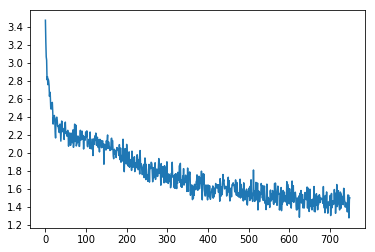

jiélì qílā
luōbótè luōbótuō
jiéěr jiélǐ
lálén lìlián
lùsī lùqiànyà
mǎlín mǎlìnà
tàlì tàilā
léilì lǐchá
shālín xuělún
héilì huòhuádé
dísī díkè
wéndénn fànlúndīng
luōsīnn kāngsītǎnsī
láiěrwén lìyàmǔ
bǎisīn bōtè
gēinà jiésēn
āllnnn ādélǐān
jiénn zhēnnà
mǎlín mǎlìān
àilì yàliè
nàiěr níěr
ādénn āěrnuòdé
bùlìsī bùláizī
qiáoān qiáodì
jàdé gàilǐ
luōěr kēlā
dén tángēn
jiélì jiéruìdé
shāméinn xímèngnà
lìlì lìlā
shāmén sàimén
ānní ānnī
luōnà lúnnàdé
bālìěr bābālā
shāléimé shāluòmǔ
ānsīsī āndōngníào
pànn pàiēn
àilìbèisī yīlìshābái
yubbnn wēngbèituō
lìsītè lìlìsī
yiléiěr xīěrwéiyà
àimén yīwàn
bùlánnn pǔlìmǎ
sīdín shǐdān
àobālā àofēilìyà
shāndé shāndí
àonnnn ōuēn
kèlìsīsī zhūlìěrsī
mǎlìsī méiwēisī
pèilìyī bǐdé
mǎilúnnn mǎdélín
mǐikè mǐjī
tàiěr xílā
léiěr lǐwéi
tuōěr tàidé
kǎisī kǎitè
kèlǐsīsī kèlǐsītíng
wéisīsī fèiqí
ménnà mǐnà
gélìsī gélādísī
léikè lìbèikǎ
ānsīsī ānnàtǎxīyǎ
wéilìkè wòěrtè
bùlánsīnī pǔlǔdēngsī
déléinn dùlǔmén
xīsī càisī
luōnà kānglādé
āndéé āndélìyà
dáléiěr dáníěr
àilì àilā
āndén ān

([('barbara', 'bā bā lā'),
  ('apollon', 'ā bō luō'),
  ('marylise', 'mǎ lì lì sī'),
  ('ronald', 'luō nài ěr dé'),
  ('birger', 'bǐ ěr gé'),
  ('yasmine', 'yǎ sī mǐn'),
  ('evan', 'ěr wén'),
  ('bobby', 'bào bǐ'),
  ('jilly', 'jí lì'),
  ('hiram', 'hǎi lēi'),
  ('lilly', 'lì lì'),
  ('abraham', 'yà bó lā hǎn'),
  ('angie', 'ān jí'),
  ('savannah', 'sà fán nà'),
  ('roderick', 'luō dé lǐ kè'),
  ('christina', 'kè lǐ sī dì nà'),
  ('vic', 'wéi kè'),
  ('tammy', 'tǎ mǐ'),
  ('wanda', 'wàng dá'),
  ('ruth', 'lù sī'),
  ('amadeo', 'ā mǎ dé ào'),
  ('mignon', 'mì nī ān'),
  ('carlos', 'kǎ luò sī'),
  ('cecilia', 'sāi xī lì yà'),
  ('ella', 'āi lā'),
  ('ruth', 'lǔ sī'),
  ('viola', 'wéi ěr lā'),
  ('wilfried', 'wēi ěr fú lǐ dé'),
  ('jonas', 'qióng nà sī'),
  ('nicolas', 'ní gǔ lā sī'),
  ('georges', 'qiáo zhì sī'),
  ('scott', 'shǐ kǎo tè'),
  ('emily', 'āi mǐ lì'),
  ('denise', 'dān nī sī'),
  ('orville', 'ào lì ěr'),
  ('kristin', 'kè lǐ sī tíng'),
  ('honey', 'hàn nī'),
  ('merle', 'mò 

In [139]:
# now actually do the thing!
hidden_size = 20
encoder2 = EncoderRNN(eng_alph.n_letters, hidden_size)
decoder2 = DecoderRNN(hidden_size, pin_alph.n_letters)

train, test = train_and_evaluate(encoder2, decoder2)
#trainIters(encoder2, decoder2, 75000, print_every=5000)

In [76]:
evaluateRandomLines(encoder2, decoder2, 10)

> matthew
= mǎ xiū
< mǎ xiē sī

> maurice
= mó lǐ sī
< mù lǐ sī

> laurel
= luó ruì ěr
< láo ěr ěr

> iban
= yī bāng
< yī bāng

> ulysses
= yóu lǐ xī sī
< yiá lì sī

> jackie
= jié kè
< jié jī

> ted
= tài dé
< tài dé

> ina
= ài nà
< ài nà

> veronica
= wéi luō ní kǎ
< wéi lēi nà

> darian
= dá lǐ ān
< dá lǐ ān



In [88]:
import datetime
def save_model(encoder, decoder):
    torch.save(encoder.state_dict(), os.path.join("..", "models", "{date:%Y-%m-%d-%H:%M:%S}-encoder".format(date=datetime.datetime.now())))
    torch.save(decoder.state_dict(), os.path.join("..", "models", "{date:%Y-%m-%d-%H:%M:%S}-decoder".format(date=datetime.datetime.now())))

save_model(encoder1, decoder1)

In [84]:
def load_model(encoder_path, decoder_path):
    encoder1 = EncoderRNN(eng_alph.n_letters, hidden_size)
    decoder1 = DecoderRNN(hidden_size, pin_alph.n_letters)
    encoder1.load_state_dict(torch.load(encoder_path))
    decoder1.load_state_dict(torch.load(decoder_path))
    return encoder1, decoder1

'abcde'

In [47]:
sorted(pin_alph.index2letter.values())

[' ',
 'EOS',
 'SOS',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'w',
 'x',
 'y',
 'z',
 'à',
 'á',
 'è',
 'é',
 'ì',
 'í',
 'ò',
 'ó',
 'ù',
 'ú',
 'ü',
 'ā',
 'ē',
 'ě',
 'ī',
 'ō',
 'ū',
 'ǎ',
 'ǐ',
 'ǒ',
 'ǔ',
 'ǜ']

In [53]:
#df = pd.read_csv(data_file)
max([len(x) for x in df['first name']])

11

In [37]:
"../models/decoder-2018-11-14-23:32:47"

AttributeError: 'Series' object has no attribute 'contains'

In [117]:
# specifically for pinyin - doesn't penalize wrong tones as much
def edit_distance_pinyin(str1, str2):
    cache = {}
    def recurse(str1, str2):
        # base cases
        if len(str1) == 0:
            return len(str2)
        elif len(str2) == 0:
            return len(str1)
        
        if cache.get((str1, str2), -1) != -1:
            return cache[(str1, str2)]
        # recursive case
        if str1[0] == str2[0]:
            ed = recurse(str1[1:], str2[1:])
            cache[(str1, str2)] = ed
            return ed
        if have_diff_tones(str1[0], str2[0]):
            ed = 0.5 + recurse(str1[1:], str2[1:])
            cache[(str1, str2)] = ed
            return ed
        else:
            # min of insert into 1, insert into 2, replace
            ed = 1 + min(recurse(str1, str2[1:]), recurse(str1[1:], str2), recurse(str1[1:], str2[1:]))
            cache[(str1, str2)] = ed
            return ed

    return recurse(str1, str2) #- common_chars(str1, str2)

In [125]:
# specifically for pinyin 
def have_diff_tones(v1, v2):
    result = False
    if v1 in 'āáǎàa' and v2 in 'āáǎàa':
        return True
    elif v1 in 'ēéěèe' and v2 in 'ēéěèe':
        return True
    elif v1 in 'īíǐìi' and v2 in 'īíǐìi':
        return True
    elif v1 in 'ōóǒòo' and v2 in 'ōóǒòo':
        return True
    elif v1 in 'ūúǔùu' and v2 in 'ūúǔùu':
        return True
    elif v1 in 'ǖǘǚǜü' and v2 in 'ǖǘǚǜü':
        return True
    else:
        return False

In [126]:
edit_distance_pinyin('ben', 'běn')

0.5